In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt
import deepchem as dc

2023-04-08 19:31:35.082924: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 19:31:35.120036: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 19:31:35.120613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 19:31:35.690783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))
df = pd.read_csv('T_data.csv')

In [3]:
training_cols = ['TS_comp', 'TS_host', 'TS_ligand']

In [4]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
TRAIN_SET = .8

In [5]:
X = []
X_ids = []
# one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
for k in PDBs.keys():
    X_ids.append(k)
    X.append(featurizer.featurize(PDBs[k]))
split_index = int(len(X) * TRAIN_SET)
X = [x[0] for x in X]
X_train_featurized = X[:split_index]
X_test_featurized = X[split_index:]

In [6]:
pdb_names = [i for i in X_ids]
pdb_names_train = pdb_names[:split_index]
pdb_names_test = pdb_names[split_index:]

In [7]:
x_add_train, x_add_test, y_train, y_test = [], [], [], []
for i in range(len(pdb_names_train)):
    new_df = df[(df['Id'] == pdb_names_train[i])]
    y_train.append(new_df['exp'].to_numpy()[0])
    x_add_train.append(-new_df[training_cols].to_numpy()[0])
y_train = np.array(y_train)
    
for i in range(len(pdb_names_test)):
    new_df = df[(df['Id'] == pdb_names_test[i])]
    y_test.append(new_df['exp'].to_numpy()[0])
    x_add_test.append(-new_df[training_cols].to_numpy()[0])
y_test = np.array(y_test)

In [9]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_test = [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

In [10]:
x_train = np.full([14, np.max([v.shape[0] for v in x_preprocessed_train]),
                  np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_train):
    if len(j.shape) > 1:
        x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_train = x_train.reshape([1] + list(x_train.shape))

x_test = np.full([14, np.max([v.shape[0] for v in x_preprocessed_test]),
                  np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_test):
    if len(j.shape) > 1:
        x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_test = x_test.reshape([1] + list(x_test.shape))

In [19]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import sys
import tensorflow as tf
import random


class GBGraphConvModel(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
    
  def __init__(self, batch_size):
    super(GBGraphConvModel, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(64, activation=tf.nn.sigmoid)
    self.dense3 = layers.Dense(1)
    
    ## Dense for overall
#     self.dense4 = layers.Dense(1, 
#      kernel_initializer=initializers.Constant([.5, -1, 1, 1]),
#      bias_initializer=initializers.Zeros())

#     self.dense4 = layers.Dense(1, 
#          kernel_initializer=initializers.Constant([.5, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]),
#          bias_initializer=initializers.Zeros(), activation=tf.keras.activations.relu)

  def call(self, inputs):
#     x_feat, x_add = inputs[0], inputs[1]
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 3])

    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    model_var = self.dense3(model_var)
#     binding_affinity = tf.concat([model_var, x_add], axis=1)
#     ddg = self.dense4(binding_affinity)

#     tf.print(self.dense4.weights, output_stream="file://weights.txt", summarize=30)
#     tf.print(binding_affinity[0], output_stream="file://binding_a.txt", summarize=30)
#     tf.print(ddg[0], output_stream="file://ddg.txt")
#     tf.print(model_var, output_stream="file://model_var.txt", summarize=30)
#     tf.print("-------------------------", output_stream=sys.stdout)
    return model_var

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model = GBGraphConvModel(split_index)
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error)
K.set_value(model.optimizer.learning_rate, 0.001)

In [20]:
model.input_shapes = [i.shape for i in x_preprocessed_train]
history = model.fit(x_train, y_train.reshape([1, -1]), epochs=20)

Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 1.6949
Epoch 2/20
1/1 [==============================] - 0s 55ms/step - loss: 1.8154
Epoch 3/20
1/1 [==============================] - 0s 48ms/step - loss: 1.6589
Epoch 4/20
1/1 [==============================] - 0s 54ms/step - loss: 1.6257
Epoch 5/20
1/1 [==============================] - 0s 52ms/step - loss: 1.6122
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 1.6100
Epoch 7/20
1/1 [==============================] - 0s 51ms/step - loss: 1.6091
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 1.6089
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 1.6087
Epoch 10/20
1/1 [==============================] - 0s 50ms/step - loss: 1.6086
Epoch 11/20
1/1 [==============================] - 0s 49ms/step - loss: 1.6087
Epoch 12/20
1/1 [==============================] - 0s 49ms/step - loss: 1.6090
Epoch 13/20
1/1 [==============================] - 0s 48ms/step

In [21]:
model.input_shapes = [i.shape for i in x_preprocessed_test]
model.modify_graphgather(len(X) - split_index)
model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 1s 604ms/step - loss: 3.1661


3.16605281829834

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


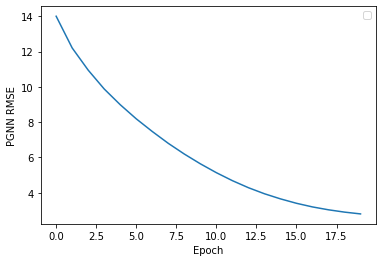

In [18]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('PGNN RMSE')
plt.legend()

# DD

In [26]:
model.input_shapes = [i.shape for i in x_preprocessed_test]
model.modify_graphgather(len(X) - split_index)
model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 1s 588ms/step - loss: 3.2730


3.2729909420013428

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


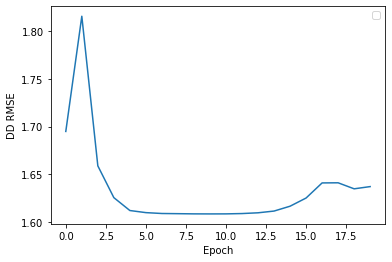

In [22]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('DD RMSE')
plt.legend()